This notebook contains first descriptive plots to get the intuition about the inputs to the simulation.

The structure is the following:
* reference matrices
* mask wearing data (total, per age group)
* average contact numbers (total, per age group)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import cycler
from datetime import datetime, timedelta
import json
import os
from warnings import filterwarnings

# from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from main import Simulation

filterwarnings('default')
def_cycler = plt.rcParams['axes.prop_cycle']
os.makedirs("./plots", exist_ok=True)
%matplotlib inline

In [3]:
plt.rcParams["font.size"] = 18
plt.rcParams["figure.facecolor"] = "white"

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Different reference matrix options

## Online reference matrix

In this version, we estimate reference proxy contact numbers before COVID from the responses of the online survey
referring to the reference period ($OR$ - online reference proxy). We use responses of users from mid-April until
the end of June (`2020/04/14-2020/06/30`), because people tend to underestimate their reference proxy contacts
as pre-COVID times are getting further.

Unfortunately, we don't have online reference proxy contact numbers for children ($OR_{k}$ -
online reference proxy kids), and the representative proxy contact numbers ($RR$ - representative reference proxy)
are consistently higher than in the online survey (so we cannot automatically fill the missing children columns from
the representative survey).

Therefore, we try to infer online reference kid proxy contacts ($OR_{k}$) by multiplying their September online actual
proxy contacts ($OA_{k}$ - online actual proxy kids) with the fraction of the representative reference proxy ($RR_{k}$
- representative reference proxy kids) and representative actual proxy contacts ($RA_{k}$ -
representative actual proxy kids). We use September data for the online actual kid proxy contacts,
because schools were open.
Maybe instead of the above text, this equation is somewhat more readable, for every matrix element for kids:

$$OR_{k} = OA_{k,\ \mathrm{Sept}}\frac{RR_{k,\ \mathrm{May}}}{RA_{k,\ \mathrm{Sept}}}$$

Here are the multipliers visually for the first 3 columns (age<18) for weekdays and weekends:
![](./notebook/online_reference_estimation_1.png)

**Contacts between 0-2 and 7 age groups are completely missing from $RR$, it cancels out every other values.**

For both the estimation of $OR_{a}$ (adults) and $OR_{k}$ (kids), we have separate matrices for weekdays and weekends.
Here are the estimated weekend-weekday matrices for the kids, then for the adults:

![](./notebook/online_reference_estimation_2.png)

**There are only 8 days in the dataset from which we estimate weekend kid contacts. It is clearly not enough,
many of the cells don't contain any values!**
![](./notebook/online_reference_estimation_3.png)


We can observe that the second age group consists of both kids (15-17) and adults (18-25),
so we have to mix that column according to the proportions within
the age group ($N_{15-17} = 287712$, $N_{18-25}=1 371 985$, source https://www.ksh.hu/interaktiv/korfak/orszag.html).

$$OR^{2nd\ col} = \frac{N_{15-17}}{N_{15-25}}\cdot OR_{k}^{2nd\ col} +
\left(1-\frac{N_{15-17}}{N_{15-25}}\right)\cdot OR_{a}^{2nd\ col}$$

After having calculated / estimated, and put together the two matrix parts $OR_k$ and $OR_a$, we get the final $OR$ as:

$$OR = \frac{5\cdot OR^{weekday} + 2\cdot OR^{weekend}}{7}$$.

![](./notebook/online_reference_estimation_4.png)

The reference matrix $R$ is then the sum of $OR$, and the family "background" matrix $F$ for the same time period
(`2020/04/14-2020/06/30`):

$$R = OR + F.$$

![](./notebook/online_reference_estimation_5.png)

The resulting matrix file is located at `contact_matrix/results/reference_online.csv` in the repo.
The then select a literature $R_0$ value corresponding to this contact matrix.

## Representative reference matrix

In this version, we use the estimated reference contact numbers from the representative survey.
The problem is that the representative survey gives consistently larger contact numbers than the online survey,
thus, it might lead to an underestimation of $R_0$ because of the unrealistic drop in the average contact numbers with
respect to the reference period.

The matrix, the previous online reference matrix, and the difference between the two:

![](./notebook/representative_reference_estimation_1.png)

The representative reference matrix can be found at `contact_matrix/results/reference_representative.csv`.
We then select a literature $R_0$ value corresponding to this contact matrix.

## Using a selected timeframe as the reference period

Here, we try to pinpoint a selected timeframe, where we use the $OA+F$ (online actual + family) contact matrix
as a reference matrix $TR$ (temporal reference), and the we get the corresponding $R_0$ calculated from the
official infection data to calculate the transmission rate $\beta$.

The problem here are the initial values in the compartments of a model, e.g. latent infections.
The assumption that the whole population is susceptible at this timepoint is not a good IC.

We tried with selecting one week between `2020/08/30` and `2020/09/06`. The selection is done in the `Simulation` class,
but I show this default selection compared to $OR$ and $RR$, the previous reference matrices, below.
![](./notebook/temporal_reference_estimation_1.png)
![](./notebook/temporal_reference_estimation_2.png)


# Masking percentage

The next figure shows the global masking percentage extracted from the online answers, created using
the same weighting scheme as for the contact matrices.

In [4]:
plt.rcParams["font.size"] = 18
plt.rcParams["figure.facecolor"] = "white"

In [5]:
df = pd.DataFrame(
    json.load(open('./contact_matrix/results/dynmatrix_step_1d_window_7d_v10_kid_reduced_all.json'))
)

<ipython-input-5-4a3a89a9fbb7>:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='contact_matrix/results/dynmatrix_step_1d_window_7d_v10_kid_reduced_all.json' mode='r' encoding='UTF-8'>
  df = pd.DataFrame(json.load(open('contact_matrix/results/dynmatrix_step_1d_window_7d_v10_kid_reduced_all.json')))


In [6]:
df.head()

,mode,number_of_users,actual_outside_proxy,actual_inside_proxy,family,contact_matrix,contact_matrix_std,seasonality_index,start_ts,start_date,...,reference_weekend,std_actual_outside_proxy,avg_actual_outside_proxy,avg_actual_inside_proxy,avg_family,avg_actual_outside_proxy_grouped,avg_actual_inside_proxy_grouped,avg_family_grouped,avg_masking,avg_masking_grouped
0,both,4423,"[[0.07626609024261442, 0.06042590965260531, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.23593146805936643, 0.08572349860134047, 0....","[[0.31219755830198087, 0.1461494082539458, 0.1...",None,None,1.585008e+09,2020-03-24,...,"[[0.0, 0.0, 0.4339567652397764, 0.949885520411...","[[0.5003788137498417, 0.8088893294665392, 0.13...",0.908116,0.0,1.793314,"{'0.0': 1.331681645633003, '1.0': 0.3546745084...","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 1.942478037314115, '1.0': 2.7242384294...",NaN,"{'0.0': None, '1.0': None, '2.0': None, '3.0':..."
1,both,8916,"[[0.022067616711500534, 0.01855827887773491, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.36212924792047896, 0.1028072003585098, 0.0...","[[0.3841968646319795, 0.12136547923624472, 0.0...",None,None,1.585094e+09,2020-03-25,...,"[[0.0, 0.0, 0.4102603168715429, 0.698559620735...","[[0.2957124692171226, 0.45488701303322193, 0.0...",1.038133,0.0,1.621769,"{'0.0': 0.37918721023071067, '1.0': 0.12982276...","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 2.3494793751129825, '1.0': 2.909373846...",0.452860,"{'0.0': None, '1.0': None, '2.0': 0.2834974266..."
2,both,16155,"[[0.05363496269863447, 0.10953264551130465, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.3873841404432674, 0.3337747765227296, 0.03...","[[0.4410191031419019, 0.4433074220340342, 0.04...",None,None,1.585181e+09,2020-03-26,...,"[[0.0, 0.0, 0.5044087952890286, 0.749592359834...","[[0.5563290636161119, 0.8236803043170562, 0.06...",1.152354,0.0,1.587644,"{'0.0': 0.48955320942777714, '1.0': 0.72056238...","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 2.096236591524658, '1.0': 2.7543880445...",0.445341,"{'0.0': None, '1.0': None, '2.0': 0.2665610142..."
3,both,32235,"[[0.055870309322929135, 0.007740991090782727, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.3807447441513295, 0.091845356804199, 0.038...","[[0.4366150534742586, 0.09958634789498173, 0.0...",None,None,1.585267e+09,2020-03-27,...,"[[0.0, 0.0, 0.4598005716577973, 0.695230075731...","[[0.6127420851625313, 0.12347397703656399, 0.0...",1.147695,0.0,1.702071,"{'0.0': 0.7220745308053214, '1.0': 0.263873213...","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 1.5824315662287791, '1.0': 2.976954304...",0.470784,"{'0.0': None, '1.0': None, '2.0': 0.2736139437..."
4,both,35660,"[[0.08144667161843273, 0.007503987327282973, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.3127639732108846, 0.04874324365340032, 0.0...","[[0.39421064482931734, 0.056247230980683294, 0...",None,None,1.585354e+09,2020-03-28,...,"[[0.0, 0.0, 0.45722293231343875, 0.70159577484...","[[0.5817954680565018, 0.118847652695932, 0.079...",1.177526,0.0,1.702221,"{'0.0': 0.8572813388459655, '1.0': 1.162177453...","{'0.0': 0.0, '1.0': 0.0, '2.0': 0.0, '3.0': 0....","{'0.0': 1.5912948624866143, '1.0': 1.763005987...",0.469728,"{'0.0': None, '1.0': None, '2.0': 0.2694256876..."


/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-7-7d4b4e0e71c5>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("./plots/mask_1.png", density=300, bbox_inches="tight")


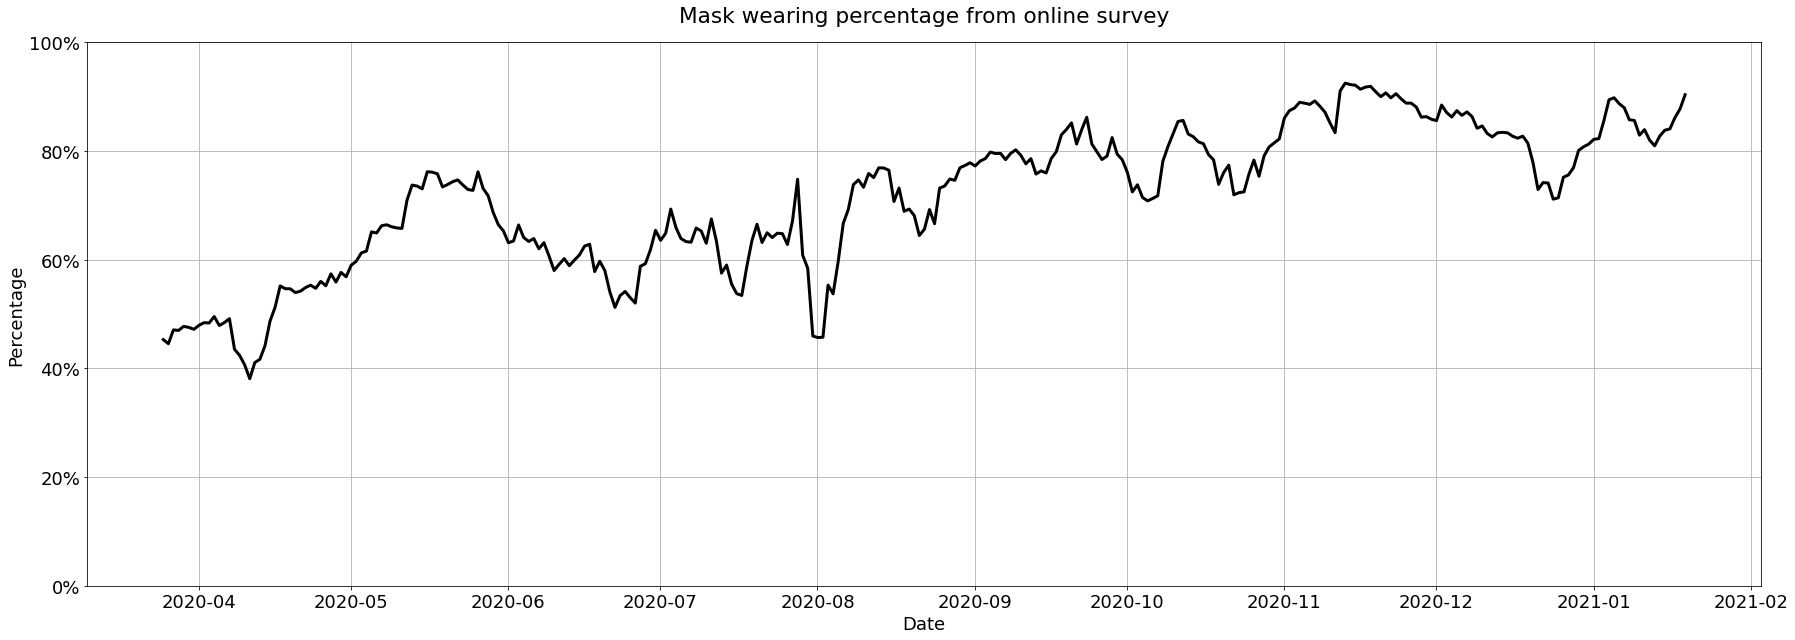

In [7]:
plt.figure(figsize=(30, 10))
plt.plot([datetime.fromtimestamp(t) for t in df.start_ts],
         df.avg_masking * 100,
         'k-', lw=3)
plt.grid()
plt.ylim(0, 100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("Percentage")
plt.xlabel("Date")
plt.title("Mask wearing percentage from online survey", pad=20)
plt.savefig("./plots/mask_1.png", density=300, bbox_inches="tight")

This is broken down to age groups. For kids, we have no answers for mask percentage, for age group 7,
the eldest, the data is very-very noisy.

In [8]:
n = 7
color = plt.cm.viridis(np.linspace(0, 1, n))[:-2][::-1]
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-9-ecf1c1c01890>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("./plots/mask_2.png", density=300, bbox_inches="tight")


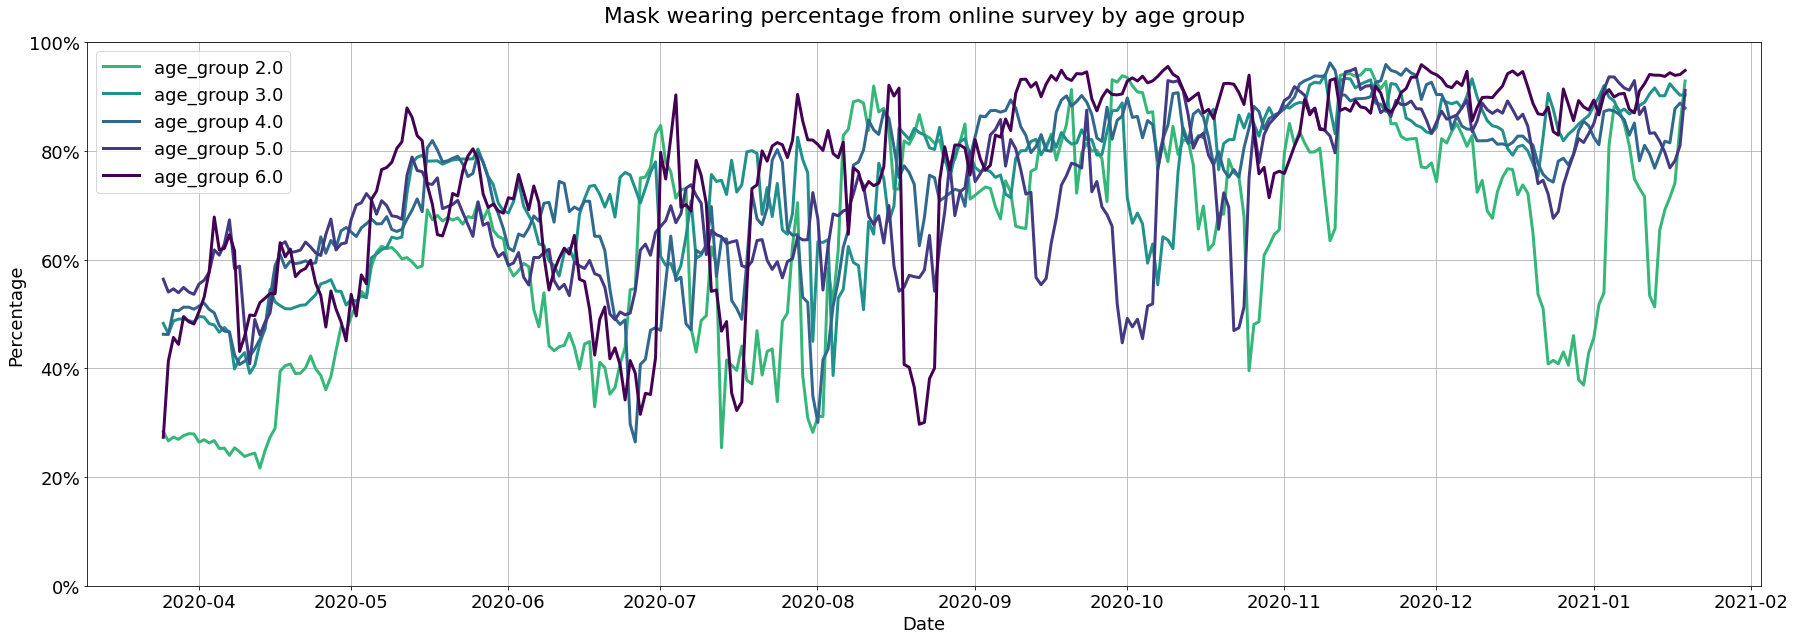

In [9]:
plt.figure(figsize=(30, 10))
for i in range(2, 7):
    plt.plot([datetime.fromtimestamp(t)
              for t in df.start_ts], df.avg_masking_grouped.map(lambda d: d[str(float(i))]) * 100,
             label="age_group " + str(float(i)), lw=3)
plt.grid()
plt.legend()
plt.ylim(0, 100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("Percentage")
plt.xlabel("Date")
plt.title("Mask wearing percentage from online survey by age group", pad=20)
plt.savefig("./plots/mask_2.png", density=300, bbox_inches="tight")

An artificially smoothed version with a 10-day sliding window average.

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-5a3b2e517c92>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("./plots/masking.png", density=300, bbox_inches="tight")


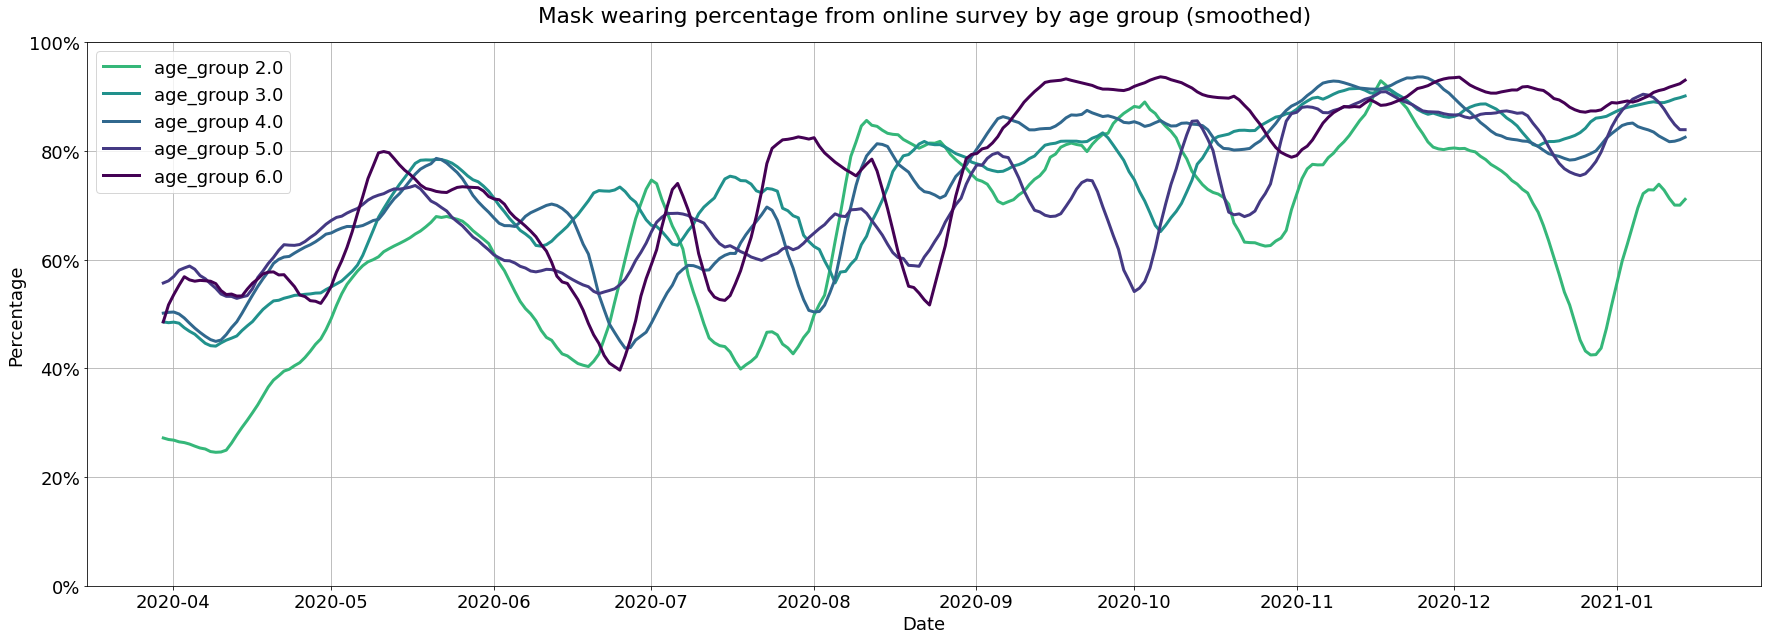

In [10]:
plt.figure(figsize=(30, 10))

N = 11

for i in range(2,7):
    plt.plot(
        [datetime.fromtimestamp(t) for t in df.start_ts][5:][:-5],
        np.convolve(df.avg_masking_grouped.map(lambda d: d[str(float(i))]) * 100, np.ones(N) / N, mode='valid'),
        label="age_group " + str(float(i)),
        lw=3)
plt.grid()
plt.legend()
plt.ylim(0, 100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("Percentage")
plt.xlabel("Date")
plt.title("Mask wearing percentage from online survey by age group (smoothed)", pad=20)
plt.savefig("./plots/masking.png", density=300, bbox_inches="tight")

# Contact numbers

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-ed4434b49647>:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "density" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("./plots/mask_1.png", density=300, bbox_inches="tight")


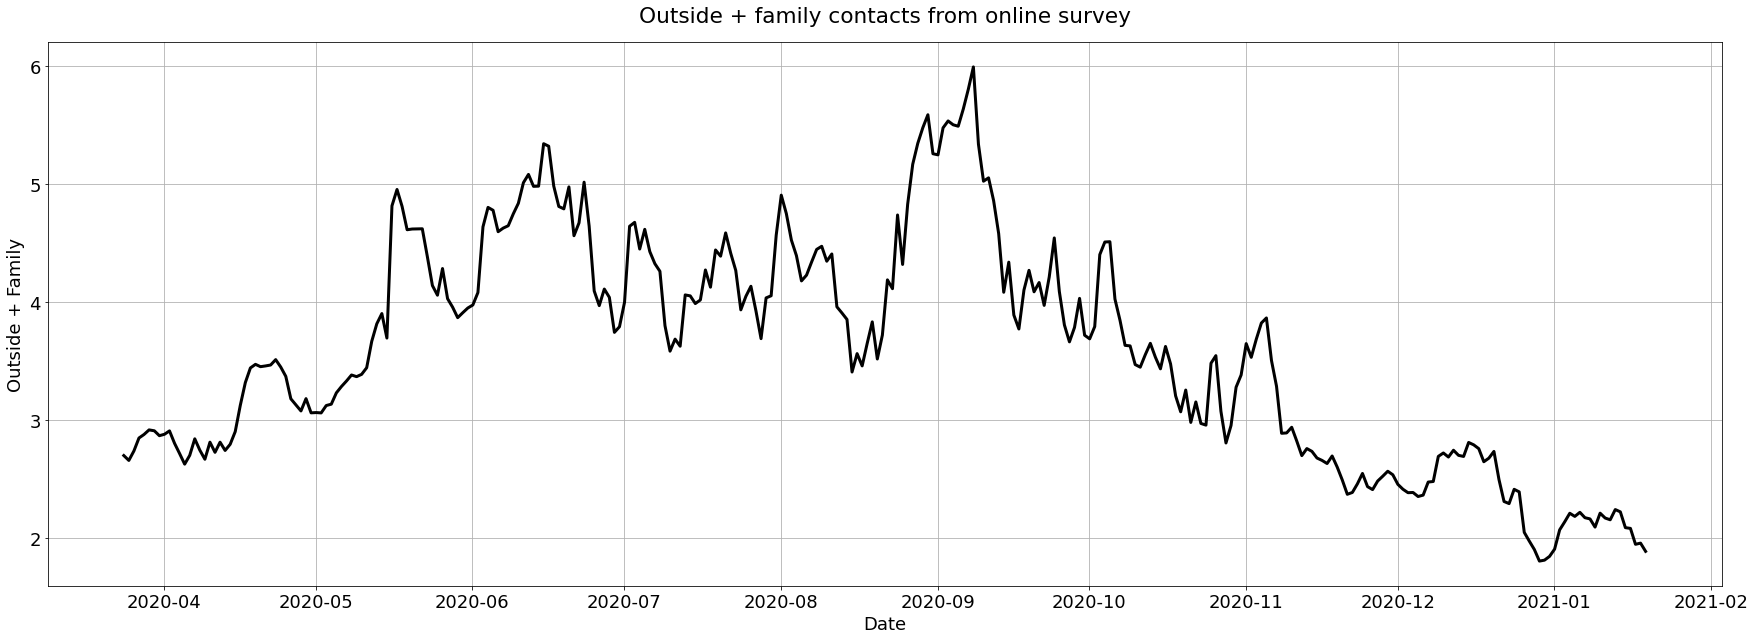

In [11]:
plt.figure(figsize=(30, 10))
plt.plot([datetime.fromtimestamp(t) for t in df.start_ts],
         df.avg_actual_outside_proxy + df.avg_family,
         'k-', lw=3)
plt.grid()
plt.ylabel("Outside + Family")
plt.xlabel("Date")
plt.title("Outside + family contacts from online survey", pad=20)
plt.savefig("./plots/mask_1.png", density=300, bbox_inches="tight")

In [12]:
n = 10
color = plt.cm.viridis(np.linspace(0, 1, n))[:-2][::-1]
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Proxy+ family contacts from online survey by age group (smoothed)')

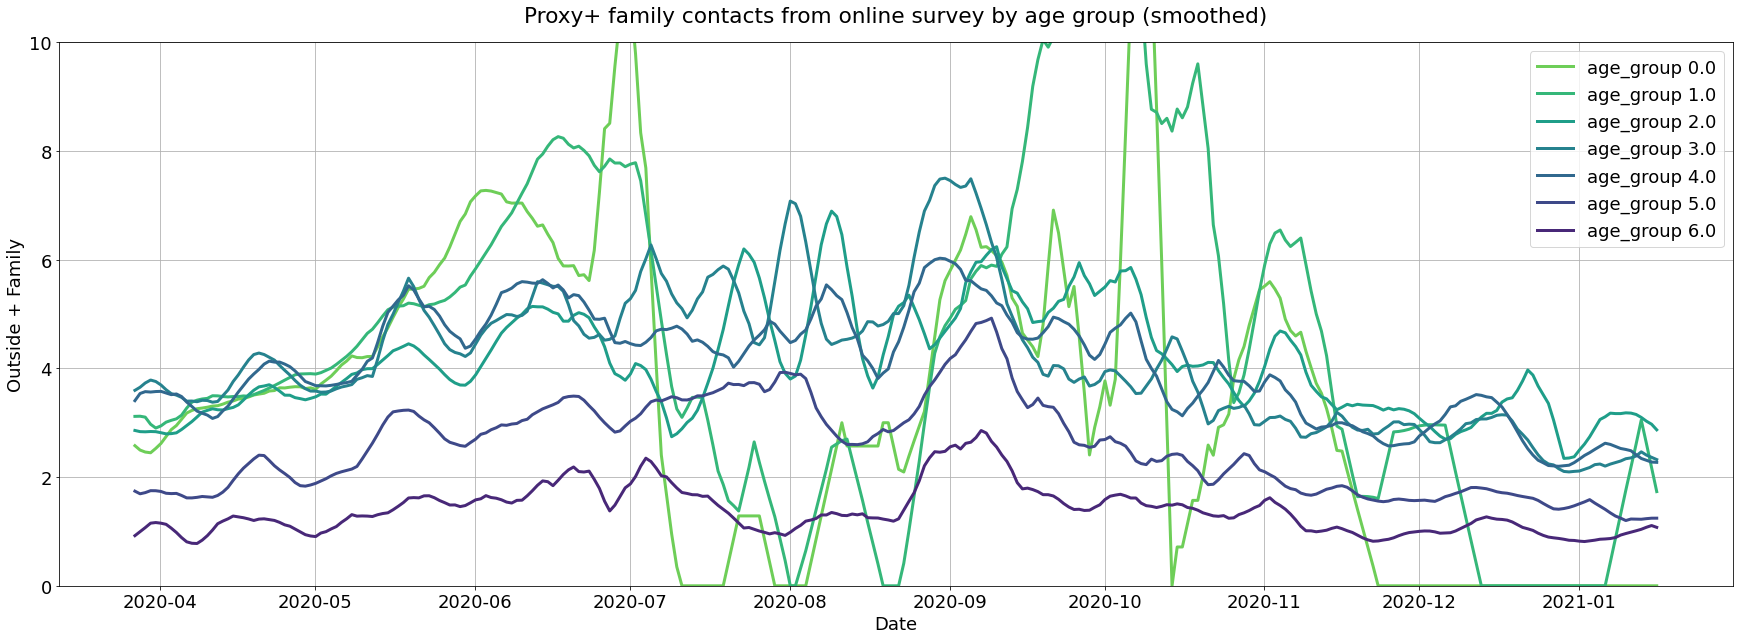

In [13]:
plt.figure(figsize=(30, 10))

N = 3

for i in range(7):
    plt.plot(
        [datetime.fromtimestamp(t) for t in df.start_ts][N:][:-N],
        np.convolve(df.avg_actual_outside_proxy_grouped.map(lambda d: d.get(str(float(i)), 0)),
                    np.ones(2 * N + 1) / (2 * N + 1), mode='valid')+\
        np.convolve(df.avg_family_grouped.map(lambda d: d.get(str(float(i)), 0)),
                    np.ones(2 * N + 1) / (2 * N + 1), mode='valid'),
        label="age_group " + str(float(i)),
        lw=3)
plt.grid()
plt.legend()
plt.ylabel("Outside + Family")
plt.xlabel("Date")
plt.ylim(0, 10)
plt.title("Proxy+ family contacts from online survey by age group (smoothed)", pad=20)
# plt.savefig("./plots/masking.png",density=300,bbox_inches="tight")

# Results of simulations

## Globally reduced large matrix element

In [14]:
plt.rcParams['axes.prop_cycle'] = def_cycler

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
sim_1 = Simulation(
    contact_data_file="dynmatrix_step_1d_window_7d_v8_avg.csv",
    contact_num_data_file="dynmatrix_step_1d_window_7d_v8_contactnum.csv"
)

sim_2 = Simulation(
    contact_data_file="dynmatrix_step_1d_window_7d_v9_kid_reduced_avg.csv",
    contact_num_data_file="dynmatrix_step_1d_window_7d_v9_kid_reduced_contactnum.csv"
)

# Call simulate() method to get r_eff values for the contact matrices
sim_1.simulate()
sim_2.simulate()

In [16]:
# Calculate datetime from simulation point timestamps for plotting purposes
t1 = [datetime.fromtimestamp(t) for t in sim_1.timestamps]
t2 = [datetime.fromtimestamp(t) for t in sim_2.timestamps]

In [17]:
# data from the webpage of Ferenci Tamas
df = sim_1.data.reference_r0_data

In [18]:
temp = pd.read_csv('data/tesztpozitivitas.csv',sep=";")
temp["pos"] = temp["Tesztpozitivitás [%]"].map(lambda s: float(s.replace(",", ".")))
temp["date"] = temp["Dátum"].map(lambda d: datetime.strptime(d, "%Y-%m-%d").strftime('%m/%d/%Y'))

In [19]:
df["pos"] = df["date"].map(dict(zip(temp["date"], temp["pos"])))
df["casenum"] = df["date"].map(dict(zip(temp["date"], temp["Napi esetszám [fő/nap]"])))

(array([764., 202., 142.,  78.,  30.,   8.,   4.,   0.,   0.,   8.]),
 array([ 0.        ,  6.86175755, 13.72351511, 20.58527266, 27.44703022,
        34.30878777, 41.17054533, 48.03230288, 54.89406044, 61.75581799,
        68.61757555]),
 <BarContainer object of 10 artists>)

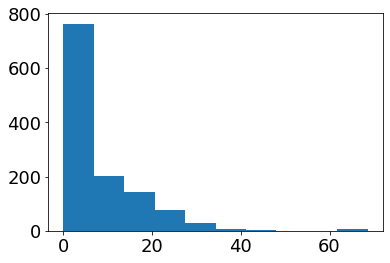

In [20]:
plt.hist(df["pos"])

In [21]:
# source https://www.ksh.hu/docs/hun/xstadat/xstadat_evkozi/e_met001.html
idojaras = pd.read_excel("data/idojaras.xls", header=[0, 1, 2], index_col=[0, 1])
honapok = {'J':1, 'F':2, 'M':3, 'Á':4, 'Mj':5, 'Jú':6, 'Jl':7, 'Au':8, 'Sz':9, 'O':10, 'N':11, 'D':12, 'J–D':0}
idojaras.index = idojaras.index.map(lambda t: str(int(t[0])) + '-' + str(honapok.get(t[1])).zfill(2))
idojaras.columns = ['temp', 'temp_max', 'temp_min', 'prec_days', 'prec_mm', 'sunny_hours', 'windy_days']
idojaras = idojaras[idojaras.index.map(lambda s: '00' not in s and ('2020' in s or '2021' in s))]
idojaras["date"] = idojaras.index.map(lambda s: datetime.strptime(s, '%Y-%m'))

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [22]:
# representative contact numbers
rdf = pd.read_csv('contact_matrix/results/Repr_SumWDKFMtx_weightnorm.csv',sep=":|,",header=None)
rdf.replace('reference','03_2020',inplace=True)
rdf["date"] = rdf[0].map(lambda s: datetime(year=int(s[-4:]),month=int(s[0:2]),day=1)+timedelta(days=30))
rdf.drop(0,axis=1,inplace=True)
rdf.set_index("date",inplace=True)
rdf = rdf.T
rdf["pos"] = (rdf.index-1)%8

<ipython-input-22-6e32e5262431>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rdf = pd.read_csv('contact_matrix/results/Repr_SumWDKFMtx_weightnorm.csv',sep=":|,",header=None)


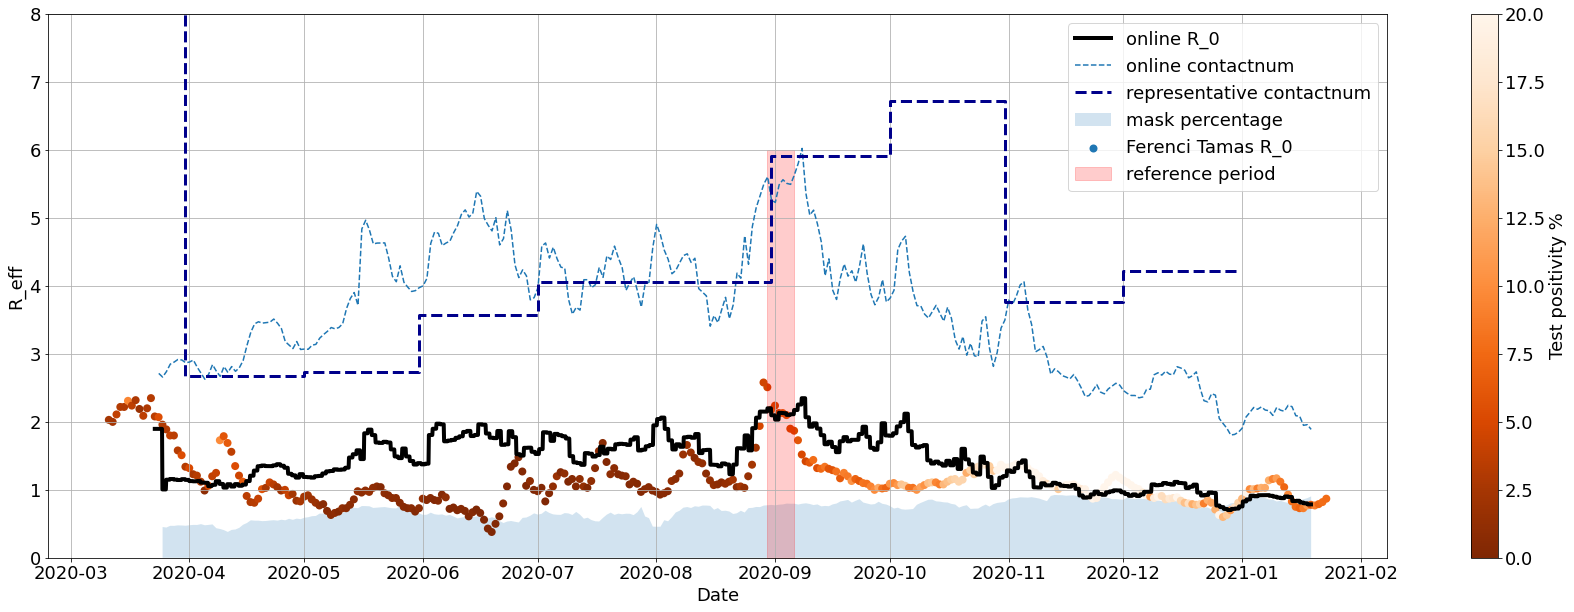

In [23]:
plt.figure(figsize=(30,10))

# simulated R-values
# plt.plot(t1, sim_1.r_eff_plot, label="original", color="lightgrey")
plt.plot(t2, sim_2.r_eff_plot, label="online R_0", color="black", lw=4)

# average contact numbers
plt.plot(
    [datetime.fromtimestamp(t) for t in sim_1.data.contact_num_data["start"]], 
    sim_1.data.contact_num_data["outside"] + sim_1.data.contact_num_data["family"],
    '--',
    label="online contactnum")

# representative contact numbers
plt.step(rdf.groupby("pos").sum().mean().index,rdf.groupby("pos").sum().mean(),'--',
         lw=3, c="darkblue", label="representative contactnum")

# masks
plt.fill_between(
    [datetime.fromtimestamp(t) for t in sim_1.data.contact_num_data["start"]], 
    sim_1.data.contact_num_data['mask_percentage'].map(float),
    alpha=0.2,
    label="mask percentage")

# reference R-values from Tamas Ferenci
for m in df["method"].unique()[[1]]:
    sdf = df[df["method"] == m]
    # positivity rate
    plt.scatter(sdf["datetime"],sdf["r0"],
                lw=2, c=sdf["pos"], cmap="Oranges_r",
                vmin=0, vmax=20, label="Ferenci Tamas R_0")
    # errorbar
#     plt.fill_between(sdf["datetime"] - timedelta(days=0), sdf["ci_lower"], sdf["ci_upper"],
#                      color='orange', alpha=0.2)
    # casenum
#     N = 3
#     plt.plot(sdf["datetime"],np.convolve(sdf["casenum"] / 1000, np.ones(2 * N + 1) / (2 * N + 1), mode='same'),
#              'r-', lw=4, alpha=0.3, label="Number of pos. cases")
    
plt.colorbar(label="Test positivity %")
    
# reference R_0 period
d1,d2 =  sim_2.baseline_cm_date
plt.fill_betweenx(
    np.linspace(0, 6, 100),
    datetime.strptime(d1,'%Y-%m-%d'), 
    datetime.strptime(d2,'%Y-%m-%d'),
    color='r',
    alpha=0.2,
    label="reference period")

# 

# formatting
plt.xlabel("Date")
plt.ylabel("R_eff")
plt.ylim(0,8)
plt.grid()
plt.legend()


# # temperature
# ax2 = plt.gca().twinx()
# ax2.step(idojaras["date"].tolist()[2:] + [idojaras["date"].iloc[-1]],
#          idojaras["temp"].tolist()[2:] + [idojaras["temp"].iloc[-1]],
#          lw=2, c="purple", label="temperature")
# ax2.set_ylabel(r"Avg. temperature $(^\circ C)$")
# ax2.legend()


/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


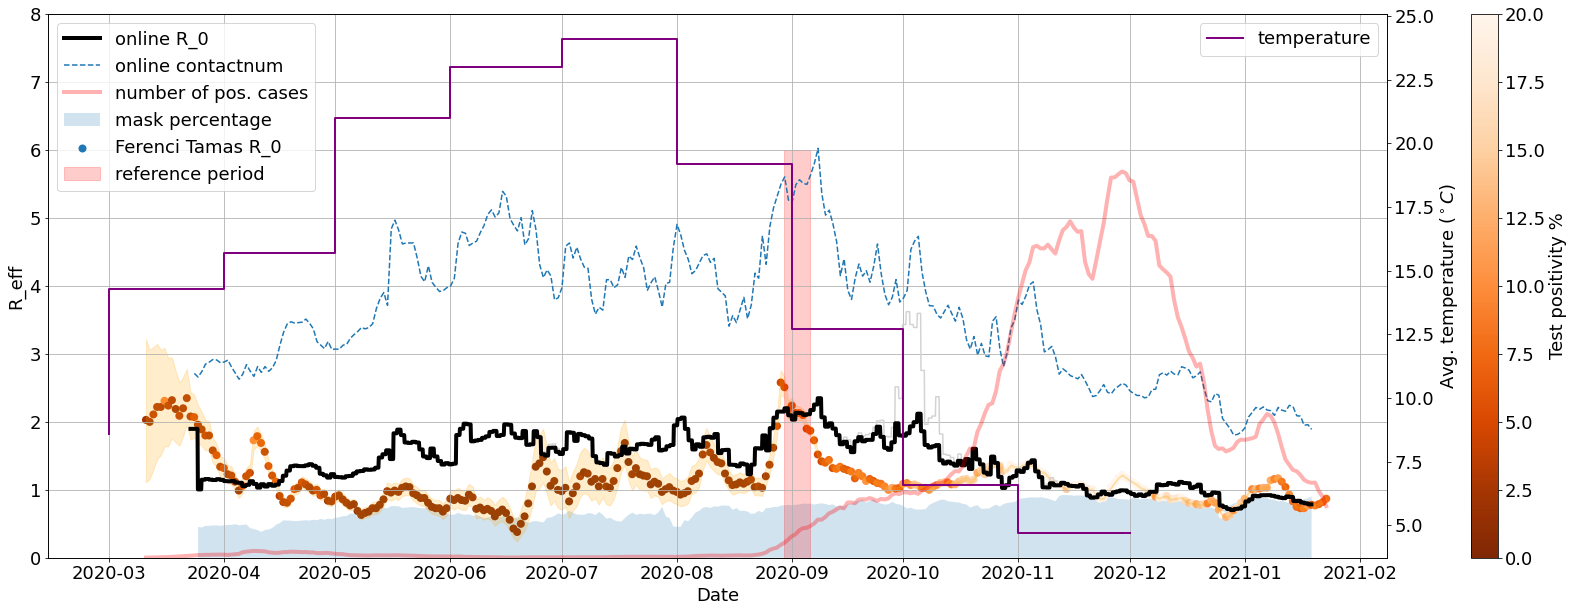

In [24]:
plt.figure(figsize=(30,10))

# simulated R-values
plt.plot(t1, sim_1.r_eff_plot, color="lightgrey")
plt.plot(t2, sim_2.r_eff_plot, label="online R_0", color="black", lw=4)

# average contact numbers
plt.plot(
    [datetime.fromtimestamp(t) for t in sim_1.data.contact_num_data["start"]], 
    sim_1.data.contact_num_data["outside"] + sim_1.data.contact_num_data["family"],
    '--',
    label="online contactnum")

# masks
plt.fill_between(
    [datetime.fromtimestamp(t) for t in sim_1.data.contact_num_data["start"]], 
    sim_1.data.contact_num_data['mask_percentage'].map(float),
    alpha=0.2,
    label="mask percentage")

# reference R-values from Tamas Ferenci
for m in df["method"].unique()[[1]]:
    sdf = df[df["method"] == m]
    # positivity rate
    plt.scatter(sdf["datetime"] - timedelta(days=0), sdf["r0"],
                lw=2, c=sdf["pos"], cmap="Oranges_r",
                vmin=0, vmax=20, label="Ferenci Tamas R_0")
    # errorbar
    plt.fill_between(sdf["datetime"] - timedelta(days=0), sdf["ci_lower"], sdf["ci_upper"],
                     color='orange', alpha=0.2)
    # casenum
    N = 3
    plt.plot(sdf["datetime"],np.convolve(sdf["casenum"] / 1000, np.ones(2 * N + 1) / (2 * N + 1), mode='same'),
             'r-', lw=4, alpha=0.3, label="number of pos. cases")
    
plt.colorbar(label="Test positivity %")
    
# reference R_0 period
d1,d2 =  sim_2.baseline_cm_date
plt.fill_betweenx(
    np.linspace(0, 6, 100),
    datetime.strptime(d1,'%Y-%m-%d'), 
    datetime.strptime(d2,'%Y-%m-%d'),
    color='r',
    alpha=0.2,
    label="reference period"
)

# 

# formatting
plt.xlabel("Date")
plt.ylabel("R_eff")
plt.ylim(0,8)
plt.grid()
plt.legend()


# temperature
ax2 = plt.gca().twinx()
ax2.step(idojaras["date"].tolist()[2:] + [idojaras["date"].iloc[-1]],
         idojaras["temp"].tolist()[2:] + [idojaras["temp"].iloc[-1]],
         lw=2, c="purple", label="temperature")
ax2.set_ylabel(r"Avg. temperature $(^\circ C)$")
ax2.legend()


## Other features of the class

In [25]:
# If r_eff_calc is False, then for the kth day (k!=0), there are `bin_size` EQUAL numbers
# r_eff_plot[0] appears once
# E.g. for k=10
k = 10
sim_1.r_eff_plot[1 + k * sim_1.bin_size:(k+1) * sim_1.bin_size]

/home/zsvizi/workspace/social-mixing-covid19-hungary/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1.12709207, 1.12709207, 1.12709207, 1.12709207, 1.12709207,
       1.12709207, 1.12709207, 1.12709207, 1.12709207])

In [26]:
# For r_eff_calc = False, you can filter for unique values
daily_r_eff = sim_1.r_eff_plot[::sim_1.bin_size]
daily_r_eff.shape

(304,)

In [27]:
# Call get_repi_r0_list() to get r_eff values (here is_r_eff_calc is set to False)
# This method fills the member variable repi_r0_list
sim_1.get_repi_r0_list()
sim_1.repi_r0_list

-------- Representative matrices --------
Baseline beta: 0.13110637481255366
For matrix BASELINE eig. val = 16.780267192540407 -> baseline r0 = 2.2
-----------------------------------------
For matrix reference eig. val = 57.63074862280115 -> r0 = 7.555758529669029
For matrix 04_2020 eig. val = 10.283749564221493 -> r0 = 1.3482651248452584
For matrix 05_2020 eig. val = 10.207891616336124 -> r0 = 1.338319664297288
For matrix 06_2020 eig. val = 11.568319131809496 -> r0 = 1.516680384046251
For matrix 08_2020 eig. val = 12.475132761834743 -> r0 = 1.6355694317094736
For matrix 09_2020 eig. val = 17.012010113814355 -> r0 = 2.2303829742966985
For matrix 10_2020 eig. val = 20.379641518905828 -> r0 = 2.671900919523148
For matrix 11_2020 eig. val = 10.304569611004855 -> r0 = 1.3509947657024528
For matrix 12_2020 eig. val = 13.371338953128284 -> r0 = 1.7530677765345357


[7.555758529669029,
 1.3482651248452584,
 1.338319664297288,
 1.516680384046251,
 1.516680384046251,
 1.6355694317094736,
 2.2303829742966985,
 2.671900919523148,
 1.3509947657024528,
 1.7530677765345357]

In [28]:
!jupyter nbconvert figures.ipynb --no-input --no-prompt

[NbConvertApp] Converting notebook figures.ipynb to html
[NbConvertApp] Writing 1572727 bytes to figures.html
